In [33]:
!pip install bertopic umap-learn hdbscan

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sentence_transformers import SentenceTransformer
from umap import UMAP
from bertopic import BERTopic
import hdbscan
import re
import json

In [35]:
class ProductGroupGenerator:
    def __init__(self, min_cluster_size=5, max_clusters=75):
        self.sentence_model = SentenceTransformer('all-MiniLM-L6-v2')
        self.tfidf = TfidfVectorizer(
            max_features=1000,
            stop_words='english',
            ngram_range=(1, 2)
        )
        self.min_cluster_size = min_cluster_size
        self.max_clusters = max_clusters
        
    def preprocess_text(self, text):
        # Convert to lowercase and remove special characters
        text = re.sub(r'[^a-zA-Z0-9\s]', ' ', str(text).lower())
        # Remove extra whitespace
        text = re.sub(r'\s+', ' ', text).strip()
        return text
        
    def generate_clusters(self, texts, method='combined', n_clusters=None):
        """
        Generate product clusters using different methods
        
        Args:
            texts: List of product titles/descriptions
            method: One of 'tfidf_kmeans', 'bert_topic', or 'combined'
            n_clusters: Optional target number of clusters
        """
        if n_clusters is None:
            n_clusters = min(len(texts) // self.min_cluster_size, self.max_clusters)
            
        processed_texts = [self.preprocess_text(text) for text in texts]
        
        if method == 'tfidf_kmeans':
            return self._cluster_tfidf_kmeans(processed_texts, n_clusters)
        elif method == 'bert_topic':
            return self._cluster_bert_topic(processed_texts)
        elif method == 'combined':
            return self._cluster_combined(processed_texts, n_clusters)
        else:
            raise ValueError("Invalid clustering method")
    
    def _cluster_tfidf_kmeans(self, texts, n_clusters):
        # Transform texts to TF-IDF vectors
        tfidf_matrix = self.tfidf.fit_transform(texts)
        
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        labels = kmeans.fit_predict(tfidf_matrix)
        
        # Get top terms for each cluster
        cluster_terms = {}
        feature_names = self.tfidf.get_feature_names_out()
        for i in range(n_clusters):
            center_indices = kmeans.cluster_centers_[i].argsort()[::-1][:5]
            cluster_terms[i] = [feature_names[idx] for idx in center_indices]
            
        return labels, cluster_terms
    
    def _cluster_bert_topic(self, texts):
        # Create embeddings
        embeddings = self.sentence_model.encode(texts)
        
        # Initialize BERTopic
        topic_model = BERTopic(
            umap_model=UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine'),
            hdbscan_model=hdbscan.HDBSCAN(
                min_cluster_size=self.min_cluster_size,
                min_samples=1,
                metric='euclidean',
                cluster_selection_method='eom'
            ),
            verbose=True
        )
        
        # Fit the model and get topics
        labels, _ = topic_model.fit_transform(texts, embeddings)
        
        # Get topic terms
        topic_terms = {}
        for topic_idx, words in topic_model.get_topics().items():
            topic_terms[topic_idx] = [word[0] for word in words[:5]]
            
        return labels, topic_terms
    
    def _cluster_combined(self, texts, n_clusters):
        # Get clusters from both methods
        print("CLUSTERING BY KMEANS")
        kmeans_labels, kmeans_terms = self._cluster_tfidf_kmeans(texts, n_clusters)
        print("CLUSTERING BY BERT")
        bert_labels, bert_terms = self._cluster_bert_topic(texts)
        
        # Create ensemble clustering
        # Convert labels to one-hot encoding
        def one_hot_encode(labels):
            n_unique = len(np.unique(labels))
            return np.eye(n_unique)[labels]
        
        kmeans_oh = one_hot_encode(kmeans_labels)
        bert_oh = one_hot_encode(bert_labels)
        
        # Concatenate features
        combined_features = np.hstack([kmeans_oh, bert_oh])
        
        # Final clustering on combined features
        print("CREATING FINAL CLUSTERING COMBINATION")
        final_kmeans = KMeans(n_clusters=n_clusters)
        final_labels = final_kmeans.fit_predict(combined_features)
        
        # Combine terms from both methods for final clusters
        final_terms = {}
        for i in range(n_clusters):
            terms_set = set()
            terms_set.update(kmeans_terms.get(i, []))
            terms_set.update(bert_terms.get(i, []))
            final_terms[i] = list(terms_set)[:5]
            
        return final_labels, final_terms

    def analyze_clusters(self, texts, labels, cluster_terms):
        """
        Analyze cluster quality and characteristics
        """
        cluster_stats = {}
        unique_labels = np.unique(labels)
        
        for label in unique_labels:
            cluster_texts = [texts[i] for i in range(len(texts)) if labels[i] == label]
            cluster_stats[label] = {
                'size': len(cluster_texts),
                'terms': cluster_terms.get(label, []),
                'sample_products': cluster_texts[:3]  # Show 3 example products
            }
            
        return cluster_stats

In [36]:
# Preparing the data
products_df = pd.read_csv('data/filtered_appliances.csv')
texts = products_df['title'] + ' ' + products_df['description']

In [37]:
# Initialize clustering class
generator = ProductGroupGenerator(min_cluster_size=50, max_clusters = 100)

In [38]:
# Run clustering
labels, cluster_terms = generator.generate_clusters(texts, method='bert_topic')

2025-03-08 12:32:45,133 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-08 12:32:47,635 - BERTopic - Dimensionality - Completed ✓
2025-03-08 12:32:47,642 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-08 12:32:47,786 - BERTopic - Cluster - Completed ✓
2025-03-08 12:32:47,801 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-03-08 12:32:48,374 - BERTopic - Representation - Completed ✓


In [39]:
# Analyze the clusters
cluster_stats = generator.analyze_clusters(texts, labels, cluster_terms)

In [40]:
# Number of products
products_df.shape[0]

7445

In [41]:
#Number of clusters
len(cluster_stats)

50

In [42]:
# Sample of group sizes and key terms
for i in range(10):
    print(f"Cluster Size: {cluster_stats[i]['size']}")
    print(f"Key Terms: {', '.join(cluster_stats[i]['terms'])}\n")

Cluster Size: 676
Key Terms: water, filter, refrigerator, nsf, filtration

Cluster Size: 311
Key Terms: refrigerator, part, defrost, the, ge

Cluster Size: 297
Key Terms: ice, maker, cubes, countertop, portable

Cluster Size: 291
Key Terms: dryer, drum, belt, pulley, kit

Cluster Size: 248
Key Terms: humidifier, honeywell, humidifiers, wick, air

Cluster Size: 222
Key Terms: washing, clothes, portable, machine, laundry

Cluster Size: 218
Key Terms: dryer, thermal, heating, fuse, element

Cluster Size: 199
Key Terms: keurig, coffee, reusable, cup, cups

Cluster Size: 195
Key Terms: frigidaire, bin, door, shelf, refrigerator

Cluster Size: 163
Key Terms: air, filter, refrigerator, lg, fresh



In [43]:
num_items = []

for cluster in cluster_stats.keys():
    num_items.append(cluster_stats[cluster]['size'])

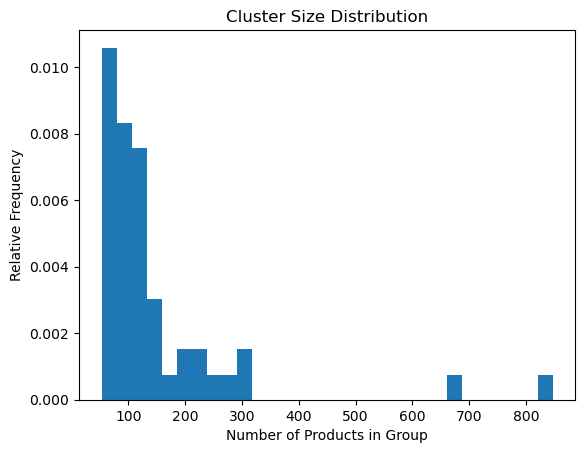

In [44]:
plt.hist(num_items, bins=30, density=True)
plt.title("Cluster Size Distribution")
plt.xlabel("Number of Products in Group")
plt.ylabel("Relative Frequency")
plt.show()

In [55]:
# Largest Group Info
cluster_stats[-1]

{'size': 847,
 'terms': ['the', 'and', 'to', 'for', 'in'],
 'sample_products': ['K&J 12 Pack Replacement Capresso Charcoal Water Filters - Replaces 4440.90 Coffee Filters Perfect Compatibility  These Capresso replacement filters made by KJ will fit all models listed below see description  Micromesh Material  Ensures the charcoal stays in the filter and does not clog up your Capresso coffee maker KJ is the highest quality of any filter currently sold  Improves Beverage Flavor  Removing impurities calcium chlorine and odors with activated charcoal filters creates the besttasting beverages  EcoFriendly Packaging  We ship your Capresso replacement filters not in a bulky box but with minimal packaging  Ultra FineGrain Charcoal  Finer charcoal granules increase the surface area exposure to water and maximize the effective filtration KJ makes the most effective replacement Capresso water filter on the market',
  'GENUINE Whirlpool 8183202 Hinge for Washing Machine Product Description This is 

In [57]:
for i in range(len(cluster_stats)-1):
    print(cluster_stats[i]['terms'])

['water', 'filter', 'refrigerator', 'nsf', 'filtration']
['refrigerator', 'part', 'defrost', 'the', 'ge']
['ice', 'maker', 'cubes', 'countertop', 'portable']
['dryer', 'drum', 'belt', 'pulley', 'kit']
['humidifier', 'honeywell', 'humidifiers', 'wick', 'air']
['washing', 'clothes', 'portable', 'machine', 'laundry']
['dryer', 'thermal', 'heating', 'fuse', 'element']
['keurig', 'coffee', 'reusable', 'cup', 'cups']
['frigidaire', 'bin', 'door', 'shelf', 'refrigerator']
['air', 'filter', 'refrigerator', 'lg', 'fresh']
['lint', 'dryer', 'screen', 'filter', 'lg']
['stove', 'covers', 'gas', 'burner', 'stovetop']
['milk', 'pitcher', 'frothing', 'latte', 'art']
['bake', 'oven', 'element', 'ge', 'appliances']
['freezer', 'beverage', 'door', 'temperature', 'wine']
['egg', 'eggs', 'storage', 'container', 'holder']
['agitator', 'washer', 'whirlpool', 'kit', 'hub']
['hose', 'hoses', 'drain', 'supply', 'braided']
['knob', 'knobs', 'stove', 'range', 'control']
['coffee', 'brew', 'pour', 'cold', 'over']

In [59]:
products_df['label'] = labels
products_df['label'].value_counts()[:5]

label
-1    847
 0    676
 1    311
 2    297
 3    291
Name: count, dtype: int64

In [61]:
cluster_terms = {i: cluster_stats[i]['terms'] for i in range(-1, len(cluster_stats)-1)}

In [63]:
with open("appliances_key_terms.json", "w") as f:
    json.dump(cluster_terms, f)

In [65]:
products_df.head()

,id,title,description,label
0,B07W42P978,WD12X10327 Rack Roller and stud assembly Kit (...,PARTS NUMBERThe WD12X10327 dishwasher top rack...,29
1,B083Q6Y54F,G.a HOMEFAVOR Cold Brew Coffee Infuser 64oz (2...,COMPLETE COLD BREW SYSTEM The Cold Brew Kit is...,19
2,B00KAS9ZMG,3-pack OnePurify Water Filter Replacement Cart...,This OnePurify refrigerator water filter conta...,0
3,B01AQHSNSM,SAMSUNG DA97-11092B Genuine OEM Ice Maker Asse...,This high quality Genuine OEM Samsung Ice Make...,32
4,B0BWCL9WCH,PARTY BARGAINS 600 Paper Coffee Filters - Whit...,PARTY BARGAINS Disposable Coffee Filters Sing...,7


In [67]:
products_df.to_csv("data/labeled_appliances.csv", index=False)